In [1]:
import lsst.meas.astrom as measAstrom
import lsst.daf.base as dafBase
import lsst.pipe.base as pipeBase
import lsst.daf.persistence as dafPersist

import lsst.afw.display.ds9 as ds9
import DiaSourceTools as DSTools

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom

import numpy as np

from astropy.table import Table

import sncosmo

%matplotlib inline

/renoir_data_00/fouchez/lsst/DM/stacks/lsstsw/2016-04-04/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [27]:
#This method allows to find matches pair to pair. Input is the list of catalogs with their visit id.
def find_paired_matches(subtr_visits):

    paired_matches = []
    for i, (visit, diaSrcs) in enumerate(subtr_visits):

        if i+1 == len(subtr_visits):
            break

        next_visit, next_diaSrcs = subtr_visits[i+1]

        match = afwTable.matchRaDec(diaSrcs, next_diaSrcs, afwGeom.Angle(1./3600., afwGeom.degrees)) 
        for m in match:
            paired_matches.append((visit, next_visit, m))
    return paired_matches

def source_distance(src1, src2):
    ra, dec = src1['coord_ra'], src1['coord_dec']
    ra2, dec2 = src2['coord_ra'], src2['coord_dec']
            
    return np.sqrt((float(ra)-float(ra2))**2+(float(dec)-float(dec2))**2)/3.14159*180*3600

def add_pair_to_list(light_curves, pair):
    
    #print pair
    for lc in light_curves:
        v, s = pair[0]
        if lc[-1][-1].getId() == pair[0][-1].getId():
            
            lc.append(pair[-1])
            return True
        elif source_distance(lc[-1][-1], pair[0][-1]) < 1:
            lc.append(pair[0])
            lc.append(pair[-1])
            return True
    light_curves.append(pair)
    return False

def add_pair_to_list2(light_curves, pair):
    
    #print pair
    for lc in light_curves:
        v, s = pair[0]
        if lc[-1][-1].getId() == pair[0][-1].getId():
            
            lc.append(pair[-1])
            return True
    light_curves.append(pair)
    return False

def threshold_light_curves(light_curves, threshold):
    t_light_curves = [lc for lc in light_curves if len(lc) >= threshold]
    return t_light_curves

#The input is a list of tuples for all matches between catalogs.
def create_light_curves(paired_matches):

    light_curves = []
    c_paired_matches = list(paired_matches)

    while len(c_paired_matches)>0:
        visit, n_visit, match = c_paired_matches.pop(0)
        points = []
        points.append((visit,match.first))
        points.append((n_visit,match.second))
        add_pair_to_list(light_curves, points) 
        
    return light_curves

def fill_gaps_on_curves(light_curves):
    light_cs_copy = list(light_curves)


    for i, lc in enumerate(light_cs_copy):
        j=i+1
        while j < len(light_cs_copy):
            compar_lc = light_cs_copy[j]


            if source_distance(lc[-1][-1], compar_lc[0][-1]) < 1:
                #print "match"
                lc.extend(compar_lc)
                light_cs_copy.pop(j)
            j+=1
    return light_cs_copy
    
            
def build_lightcurve(source_list):
    """
    Assemble a light curve data table from available files.
    """
        
    bandpasses = ['r']
  
        
    lightcurve = {}
    lightcurve['bandpass'] = []
    lightcurve['mjd'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []

  
    for visit, src in source_list:

        #print 'yep',visit
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        lightcurve['mjd'].append(visit[-1])
        lightcurve['ra'].append(src['coord_ra'])
        lightcurve['dec'].append(src['coord_dec'])
        lightcurve['flux'].append(src['base_PeakLikelihoodFlux_flux'])
        lightcurve['flux_error'].append(src['base_PeakLikelihoodFlux_fluxSigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
    lightcurve = Table(data=lightcurve)
    return lightcurve  


def get_diaSource_input_on_ccd(butler, visits, ccd):
    subtr_visits = []
    dates = []

    for visit, date in visits:

        #We check if there is actually data for the given visit (due to butler limitations) and we chose the first visit for each date
        if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}) and date not in dates:
            #print visit
        #if butler.datasetExists("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd}):   
            #print "here"
            #Keeping the dates in terms of days
            if len(dates) == 0:
                days=0
            else:
                days = np.datetime64(date)-np.datetime64(dates[0])
                days = days.item().days

            dates.append(date)

            #Recover Difference Exposure and DiaSources
            diffExp = butler.get("deepDiff_differenceExp", {'visit': visit , 'filter':'r' , 'ccd':ccd})
            diaSrcs = butler.get("deepDiff_diaSrc", {'visit': visit , 'filter':'r' , 'ccd':ccd})

            class_diaSrcs = diaSrcs.copy()
            class_diaSrcs.clear()

            #We select DiaSources above 5 Sigma
            fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

            m_sigma = np.mean(sigmas)
            t_sigma = 5*m_sigma

            sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")

            #Here we add conditions on the DiaSources set (for instance, no diaSources with negative footprints)
            for source in sources:
               
                try:
                    stamp = DSTools.get_stamp(source, diffExp)
                    stamp_clone = stamp.clone()

                    results = DSTools.detect_diasources(stamp_clone, doSmooth=True)
                    negFps = len(results.fpSets.negative.getFootprints())
                    posFps = len(results.fpSets.positive.getFootprints())

                    #if negFps == 0:
                   
                    if True:
                        #class_diaSrcs.addNew()
                        class_diaSrcs.append(source)
                        if np.isnan(source["coord_ra"]):
                            print 'nan'

                except Exception, e:
                    pass
                    #print e
            subtr_visits.append(((visit, days), class_diaSrcs))

    return subtr_visits   

In [14]:
DATADIR="/renoir_data_02/jpreyes/lsst_data/CFHTLS_master/"
butler = dafPersist.Butler(DATADIR+"/output")
visits = butler.queryMetadata("deepDiff_differenceExp", format=['visit', 'date'],dataId={'filter':'r'})
ccds = butler.queryMetadata("deepDiff_differenceExp", format=['ccd'],dataId={'filter':'r'})
#visits.remove((849685, '2006-05-24'))
#visits.remove((849686, '2006-05-24'))
#visits.remove((850586, '2006-06-02'))

In [28]:
subtr_visits = get_diaSource_input_on_ccd(butler, visits, 14)
        

In [158]:
type('coord_ra')

str

In [78]:
print subtr_visits[-1][0][0]

860146


In [80]:
#subtr_visits = get_diaSource_input_on_ccd(butler, visits, 14)
mm = afwTable.multiMatch.MultiMatch(subtr_visits[0][-1].schema, {'visit':int}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
for visit, sCat in subtr_visits:
    mm.add(sCat, {'visit':visit[0]})

res = mm.finish(removeAmbiguous=False)

In [56]:
calexp1= butler.get('calexp',{'visit':subtr_visits[1][0][0], 'ccd':14, 'filter':'r'})
wcs1 = calexp1.getWcs()
ds9.mtv(calexp1, frame =1 )

calexp2 = butler.get('calexp',{'visit':subtr_visits[2][0][0], 'ccd':14, 'filter':'r'})
wcs2 = calexp2.getWcs()
ds9.mtv(calexp2, frame =2 )

calexp3 = butler.get('calexp',{'visit':subtr_visits[3][0][0], 'ccd':14, 'filter':'r'})
wcs3 = calexp3.getWcs()
ds9.mtv(calexp3, frame =3 )

In [83]:
for r in res:
    print r['object'], r['visit']

1 836493
2 836493
2 845345
2 849685
2 850177
2 850586
2 853232
2 853539
3 836493
3 839308
3 844845
3 845345
4 836493
5 836493
5 844210
5 851057
5 853232
6 836493
7 836493
7 844210
7 844489
7 850586
7 851057
7 853232
7 853539
7 859608
8 836493
8 844210
8 844845
8 845345
9 837002
9 844210
9 850177
9 850586
9 860146
10 837002
11 837002
12 837002
12 844210
12 844845
12 845345
12 851057
13 837002
14 837002
15 837002
15 844210
15 844845
15 849685
15 852890
15 853539
15 858537
15 860146
16 837002
17 837002
18 837002
18 838853
18 844489
18 852890
18 853539
19 837002
19 850586
20 837002
20 860146
21 837002
21 844845
22 837002
23 837002
23 849685
23 850177
23 853232
23 860146
24 837002
24 845345
24 850177
24 850586
24 852890
24 853727
24 860146
25 837002
26 837002
26 844210
26 850177
26 850586
27 837002
27 844210
27 844845
27 845345
27 849685
27 850177
27 852890
27 853232
27 853539
28 837002
28 850177
28 860146
29 837002
29 844845
29 845345
29 849685
29 850586
29 852890
29 853539
29 859608
30 83

In [180]:
matches = afwTable.matchRaDec(subtr_visits[1][-1],subtr_visits[2][-1],afwGeom.Angle(1./3600., afwGeom.degrees))

In [181]:
matches

(Match(<lsst.afw.table.tableLib.SourceRecord; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::table::SourceRecord > *' at 0x7f39f42216c0> >,
             <lsst.afw.table.tableLib.SourceRecord; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::table::SourceRecord > *' at 0x7f39f42216c0> >,
             2.87755e-06),
 Match(<lsst.afw.table.tableLib.SourceRecord; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::table::SourceRecord > *' at 0x7f39f42216c0> >,
             <lsst.afw.table.tableLib.SourceRecord; proxy of <Swig Object of type 'boost::shared_ptr< lsst::afw::table::SourceRecord > *' at 0x7f39f42216c0> >,
             1.95194e-06))

In [190]:
for m in matches:
    print m.second['coord_ra']

3.74735 rad
3.74767 rad


In [192]:
for obj in subtr_visits[1][-1]:
    print obj['base_PeakLikelihoodFlux_flux']

nan
1781600.84285
nan
-8773.51634193
nan
8791.29708692
nan
19760.2825479
nan
-8277.35701274
nan
9266.05206404
nan
-8045.51715459
nan
99218.5029532
nan
12828.7410421
nan
-24715.2860591
nan
11858.4388666
nan
13259.4886944
nan
267087.061119
nan
16875.566872
nan
-38348.2526484
nan
9630.94065314
nan
12248.7803403
nan
11972.5677315
nan
9167.69102386
nan
17024.1492541
nan
260240.337523
nan
-9765.45413812
nan
11095.6695598
nan
101085.434604
nan
108271.768329
nan
9192.54813654
nan
17273.004743
nan
-9042.04460229
nan
10122.8695364
nan
9412.73742981
nan
7770.39796723
nan
9353.62487198
nan
8625.73955096
nan
1221420.4505
nan
7770.94216288
nan
7860.40300227
nan
11187.8104886
nan
8605.27015408


In [130]:
scat.Table.Catalog

lsst.afw.table.tableLib.SourceCatalog

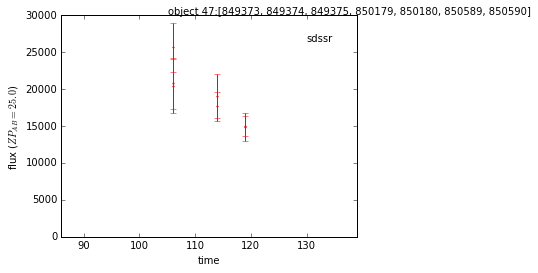

In [84]:
lc = build_lightcurve(t_light_curves[41])
#visualize_lightcurve(lc, color='red')
lc_visits = [visit[0] for visit, data in t_light_curves[41] ]
#print visits
fig = sncosmo.plot_lc(lc, color='red', xfigsize=10)
axes = fig.get_axes()
xlim = axes[0].get_xlim()
axes[0].set_xlim(xlim[0]-10, xlim[1]+10)
fig.suptitle("object "+str(i)+":"+str(lc_visits))
fig.show()

In [76]:
i = 1
for tl in t_light_curves:
    try:
        dataid_list = [{'visit': visit[0] , 'filter':'r' , 'ccd':14}  for visit, data in tl]
        source = tl[0][-1]
        DSTools.get_time_mosaic(butler, dataid_list, source, frame=i, equalize=True, title="object n. "+str(i-1))
        ds9.setMaskTransparency(100, frame=i)
        i+=1
    except Exception, e:
        
        i+=1
        print e
    


  File "src/image/Image.cc", line 92, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(321,4521),Extent2I(101,101)) doesn't fit in image 2048x4612 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(321,4521),Extent2I(101,101)) doesn't fit in image 2048x4612'



In [81]:
i=1
cl = butler.get('calexp', {'visit': 850177 , 'filter':'r' , 'ccd':14})
ds9.mtv(cl, frame=1)
for n, tl in enumerate(t_light_curves):
   
    source = tl[0][-1]
    wcs = cl.getWcs()
    x, y = wcs.skyToPixel(source['coord_ra'], source['coord_dec'])

    ds9.dot(n, x, y, frame=1, size=2)
    i+=1
    

In [5]:
diffExp = butler.get("calexp", {'visit': 849685 , 'filter':'r' , 'ccd':14})
ps = diffExp.getMetadata()
ps.get("MJD-OBS")

53879.2780288

In [6]:
diffExp = butler.get("calexp", {'visit': 849686 , 'filter':'r' , 'ccd':14})
ps = diffExp.getMetadata()
ps.get("MJD-OBS")

53879.2821085

In [ ]:
ex = get_diaSource_input_on_ccd(butler, visits, 14)

2418698.94301
1306075.55998
-18844.9559044
49691.6276782
1178423.71782
31393.2458072
14033.3041418
27983.8595353
29267.6309953
542171.004192
1144585.20726
1781600.84285
-8773.51634193
193865.928643
654741.368067
8791.29708692
19760.2825479
-8277.35701274
9266.05206404
-8045.51715459
99218.5029532
12828.7410421
-24715.2860591
11858.4388666
13259.4886944
267087.061119
16875.566872
-83342.8628472
-38348.2526484
9630.94065314
12248.7803403
11972.5677315
9167.69102386
17024.1492541
260240.337523
-9765.45413812
11095.6695598
101085.434604
108271.768329
9192.54813654
17273.004743
-9042.04460229
10122.8695364
9412.73742981
7770.39796723
9353.62487198
8625.73955096
1221420.4505
7770.94216288
14562.8391378
7860.40300227
11187.8104886
8605.27015408
8609.56119799
27357.3644999
124862.900791
3034640.09782
-126407.754159
-32641.2633549
2551207.8806
31401.5640406
-96752.8025551
-151715.314742
57317.5151066
33145.5876689
34372.2930895
23752.7036823
24079.0255126
-14732.9645109
-23721.0382502
-27534.77

In [39]:
i=1
cl = butler.get('calexp', {'visit': 851057 , 'filter':'r' , 'ccd':14})
ds9.mtv(cl, frame=1)
diaSrcs = butler.get("deepDiff_diaSrc", {'visit': 851057 , 'filter':'r' , 'ccd':14})

class_diaSrcs = diaSrcs.copy()
class_diaSrcs.clear()

#We select DiaSources above 5 Sigma
fluxes, sigmas = DSTools.get_fluxes_and_sigmas(diaSrcs, "base_PeakLikelihoodFlux_flux")

m_sigma = np.mean(sigmas)
t_sigma = 5*m_sigma

sources = DSTools.get_sources_over_sigma(diaSrcs, t_sigma, "base_PeakLikelihoodFlux_flux")

for s in sources:
    ds9.dot('o', s.getX(), s.getY(), size=10, frame=1)